In [7]:
# loading packages
import io
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.linear_model import Lasso
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [8]:
# read the uploaded CSV file into a DataFrame using pandas
df = pd.read_csv('./Cleaned Data/Features and Target (Merged).csv')
df["forward_return"] = df["forward_return"]/100

In [9]:
##这一步是为了生成一个list list里面有四个元素，每个元素是个字典，字典里面保存了我们每次rolling period
##的开始时间 结束时间，training 和 Validation以及testing的时间节点
iteration_list = []
rolling_order = 1
for i in range(1993,2013,5):
    start_date = int(str(i) + "01")
    end_date = int(str(i+15) + "01")
    training_separation_date = int(str(i+10) + "01")
    Dic = {"start_date":start_date,"end_date":end_date,
           "training_separation_date":training_separation_date,"rolling_order":rolling_order}
    rolling_order = rolling_order + 1
    iteration_list.append(Dic)
print(iteration_list)

features =['News_sentiment_3MA', 'Consumer_sentiment_3MA', 'Investor_sentiment_3MA','betaVIX', 
           'BookLeverage', 'ConvDebt', 'DolVol', 'hire', 'IdioVol3F', 'IndMom', 'MaxRet',
           'OPLeverage', 'PctAcc', 'RDIPO', 'ReturnSkew', 'Size', 'STreversal','zerotradeAlt1']

[{'start_date': 199301, 'end_date': 200801, 'training_separation_date': 200301, 'rolling_order': 1}, {'start_date': 199801, 'end_date': 201301, 'training_separation_date': 200801, 'rolling_order': 2}, {'start_date': 200301, 'end_date': 201801, 'training_separation_date': 201301, 'rolling_order': 3}, {'start_date': 200801, 'end_date': 202301, 'training_separation_date': 201801, 'rolling_order': 4}]


In [10]:
Strategy_monthly_returns = []
for value in tqdm(iteration_list): ##对每一个rolling period进行相同的操作，也就是进行training，validation到testing
    ##对于每一个rolling period，从刚刚生成list当中的字典，获得他们的不同的节点，用于分割数据
    start_date = value["start_date"]
    end_date = value["end_date"]
    training_separation_date = value["training_separation_date"]
        
    
    ##开始根据节点 分割不同的periods
    sub_period = df[(df["yyyymm"]>=start_date)&(df["yyyymm"]<end_date)]
    sub_period = sub_period.dropna(subset = features)
    training_sample = sub_period[sub_period["yyyymm"]<training_separation_date].reset_index(drop=True)
    testing_sample = sub_period[sub_period["yyyymm"]>=training_separation_date].reset_index(drop=True)
    
   
    ##用最好模型对应的参数重新train一次模型
    best_model = ensemble.RandomForestRegressor(n_estimators=1000, # Number of trees used
                                           criterion='squared_error',
                                           min_samples_leaf=500, # Minimum size of terminal cluster
                                           max_features=6, # Nb of predictive variables for each tree
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           max_samples=len(training_sample),
                                           random_state=42, n_jobs=6)

    best_model.fit(training_sample[features],training_sample['forward_return'].values)
    
    ##计算一下在这个模型之下的features importance并保存
    Features_important = pd.DataFrame(best_model.feature_importances_, features,
             columns=["value"]).sort_values(["value"],ascending=False).head(10)
    
    print(Features_important)
    
    ##开始对testing sample进行处理，首先要拿到training sample的月份，变成一个list
    Month_list = list(testing_sample[["yyyymm"]].drop_duplicates().sort_values(by="yyyymm")["yyyymm"])
    

    Top_20_returns = []
    Top_10_returns = []
    Top_5_returns = []
    Random_returns = []
    #每个月用一次模型进行预测
    for month in Month_list:
        sub_testing_sample = testing_sample[testing_sample["yyyymm"]==month]
        testing_predicted = pd.DataFrame(best_model.predict(sub_testing_sample[features]))
        testing_realized = sub_testing_sample[["forward_return"]].reset_index(drop=True)
        testing_predicted_real = pd.concat([testing_predicted,testing_realized],axis=1)
        
        #predicted value 排序 选出最高的那20个equally weighted组成我们的portfolio
        top_five = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-5:])/5
        top_ten = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-10:])/10
        top_twenty = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-20:])/20
        Random = sum(list(testing_predicted_real.sample(n=20, random_state=42)["forward_return"]))/20
        ##bottom_twenty = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[:20])/20
        
        ##存储每一个月的return到我们预先设置好的list
        Top_20_returns.append(top_twenty)
        Top_10_returns.append(top_ten)
        Top_5_returns.append(top_five)
        Random_returns.append(Random)
    
    Portfolio_monthly_return_each_testing_period = pd.DataFrame({"yyyymm":Month_list[1:],"Top_20_returns":Top_20_returns[:-1],
                                                                "Top_10_returns":Top_10_returns[:-1],"Top_5_returns":Top_5_returns[:-1],
                                                                "Random_returns":Random_returns[:-1]})
    Portfolio_monthly_return_each_testing_period["yyyymm"] = pd.to_datetime(Portfolio_monthly_return_each_testing_period['yyyymm'], format='%Y%m')
    Strategy_monthly_returns.append(Portfolio_monthly_return_each_testing_period)

Strategy_monthly_returns = pd.concat(Strategy_monthly_returns,axis = 0)

  0%|          | 0/4 [00:00<?, ?it/s]

                           value
News_sentiment_3MA      0.289271
Consumer_sentiment_3MA  0.175072
Investor_sentiment_3MA  0.121268
Size                    0.108219
IdioVol3F               0.091129
DolVol                  0.046958
STreversal              0.038653
betaVIX                 0.035106
MaxRet                  0.020988
IndMom                  0.020049


 25%|██▌       | 1/4 [00:07<00:21,  7.18s/it]

                           value
News_sentiment_3MA      0.275557
Investor_sentiment_3MA  0.155355
Size                    0.140103
Consumer_sentiment_3MA  0.133583
IdioVol3F               0.115542
STreversal              0.045250
DolVol                  0.031618
MaxRet                  0.031284
IndMom                  0.017060
PctAcc                  0.013826


 50%|█████     | 2/4 [00:14<00:14,  7.19s/it]

                           value
Consumer_sentiment_3MA  0.311403
News_sentiment_3MA      0.203707
Investor_sentiment_3MA  0.129244
Size                    0.092012
DolVol                  0.084566
IndMom                  0.035818
IdioVol3F               0.032190
MaxRet                  0.031357
STreversal              0.026125
PctAcc                  0.014021


 75%|███████▌  | 3/4 [00:20<00:06,  6.91s/it]

                           value
Consumer_sentiment_3MA  0.339711
Investor_sentiment_3MA  0.196291
News_sentiment_3MA      0.185017
Size                    0.053833
MaxRet                  0.053801
IndMom                  0.051010
DolVol                  0.029449
IdioVol3F               0.027736
PctAcc                  0.012690
ReturnSkew              0.011497


100%|██████████| 4/4 [00:26<00:00,  6.65s/it]


In [11]:
Strategy_monthly_returns['Top_20_Cumulative_Return'] = (1 + Strategy_monthly_returns['Top_20_returns']).cumprod() - 1
Strategy_monthly_returns['Top_10_Cumulative_Return'] = (1 + Strategy_monthly_returns['Top_10_returns']).cumprod() - 1
Strategy_monthly_returns['Top_5_Cumulative_Return'] = (1 + Strategy_monthly_returns['Top_5_returns']).cumprod() - 1
Strategy_monthly_returns['Random_Cumulative_Return'] = (1 + Strategy_monthly_returns['Random_returns']).cumprod() - 1

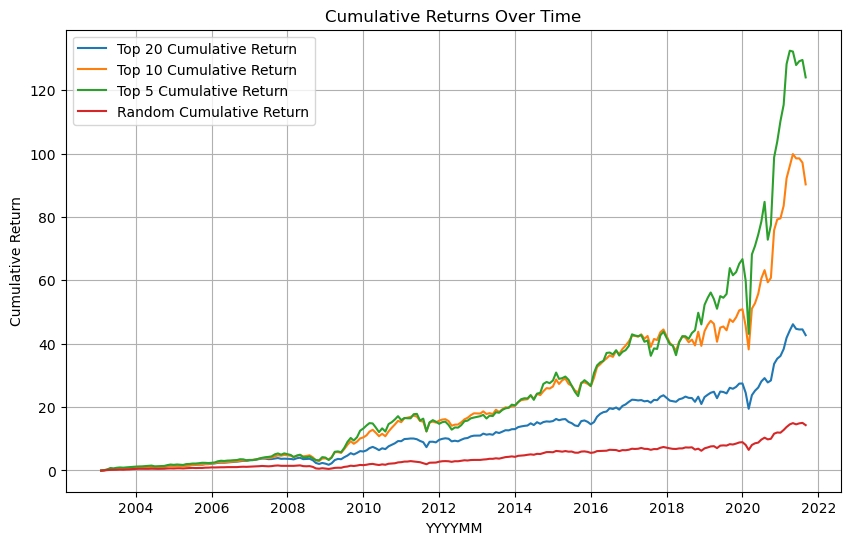

In [12]:
plt.figure(figsize=(10, 6))
Strategy_monthly_returns.set_index('yyyymm', inplace=True)
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Top_20_Cumulative_Return'], label='Top 20 Cumulative Return')
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Top_10_Cumulative_Return'], label='Top 10 Cumulative Return')
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Top_5_Cumulative_Return'], label='Top 5 Cumulative Return')
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Random_Cumulative_Return'], label='Random Cumulative Return')

# Customize the plot
plt.title('Cumulative Returns Over Time')
plt.xlabel('YYYYMM')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()